By: Adrian Ruvalcaba, Donatas Tamosauskas, Zaid Al Nouman

# Training Implementation

In [1]:
import random
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
from torchsummary import summary

from dumbbells.dataset import *
from dumbbells.agent import *
from dumbbells.q_functions import *
from dumbbells.models import *
from dumbbells.trainer import *

%load_ext autoreload
%autoreload 2

## Hyper Parameters

In [2]:
ENV = "CartPole-v1" 
MEMORY_BUFFER = 1024

GAMMA = 0.999
# You can swap this to a Deep Fully Connected NN by swapping these two architectures! 
ARCH = DeepFcDqn # CnnDqn

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200 

In [3]:
def seed_everyting(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    

def set_up(history=False):
    if history:
        dataset = HistoryDataset(ENV, MEMORY_BUFFER)
    else:
        dataset = Dataset(ENV, MEMORY_BUFFER)
    arch = ARCH(dataset.state_space.shape[0], dataset.action_space.n)
    q_func = DnnQFunction(arch, GAMMA)
    agent = Agent(
        q_func, 
        dataset.action_space, 
        dataset.state_space, 
        dataset.reward_space, 
        EPS_START, 
        EPS_END, 
        EPS_DECAY, 
    )

    return dataset, agent

## Now, let's train!

### Fully Connected Neural Network

In [4]:
# We set the seed to one we found to be good in the seed search from trainer-impl.ipynb
seed_everyting(3)

dataset, FCNNagent = set_up()

trainer = Trainer(dataset, FCNNagent, offline_update=5, batch_size=512)
trainer.train(2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:45<00:00,  8.89it/s]


Let's visualize the training process

len(dataset) = 1024
len(trainer.ep_durations) = 2000


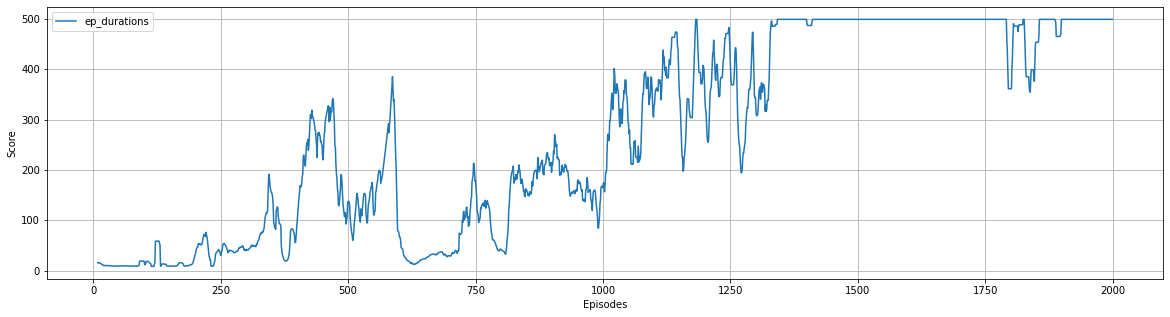

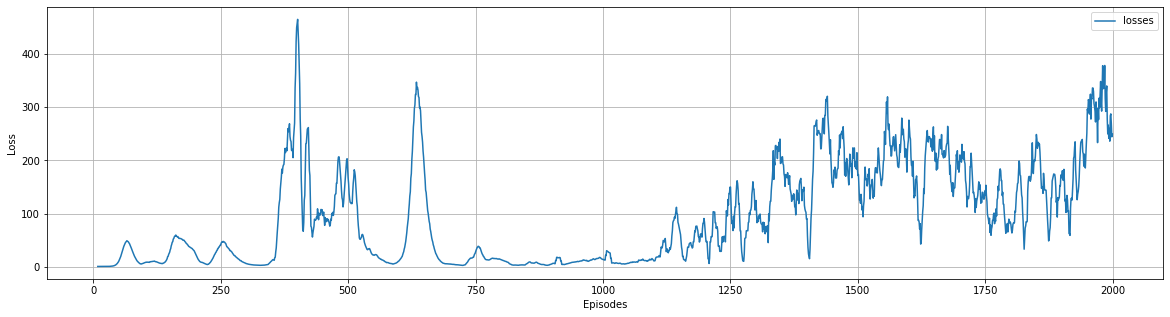

In [5]:
print(f"{len(dataset) = }")
print(f"{len(trainer.ep_durations) = }")

plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(pd.Series(trainer.ep_durations).rolling(10).mean(), label="ep_durations")
plt.legend()
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.show()

plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(pd.Series(trainer.losses).rolling(10).mean(), label="losses")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Episodes")
plt.show()

### Now let's actually see our fully connected neural network based model play!

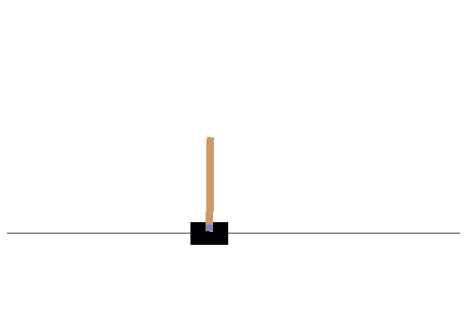

In [6]:
data = Dataset(ENV, 256, produce_gif=True)

done = False
state = data.reset()
counter = 0
for i in range(1000):
    if done:
        counter += 1
        if counter == 200:
            counter = 0
            state = data.reset()
        done = False
        continue
        
    action = FCNNagent.action(state.unsqueeze(0))
    action = action[0][0].item()
    state, reward, done = data.step(action)
    
# You can change the name of the saved gif here!
data.save_frames_as_gif(filename="FullyConnectedNNAgent.gif")

### Convolutional Neural Network
First we'll set our hyperparameters:

In [7]:
MEMORY_BUFFER = 1024  # 10000

GAMMA = 0.999
ARCH = CnnDqn

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100 

Then we'll train the model!

In [8]:
seed_everyting(3)

dataset, CNNagent = set_up(history=True)

trainer = Trainer(dataset, CNNagent, offline_update=5, batch_size=512)
trainer.train(2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:20<00:00,  4.54it/s]


Let's visualize the training process!

len(dataset) = 1024
len(trainer.ep_durations) = 2000


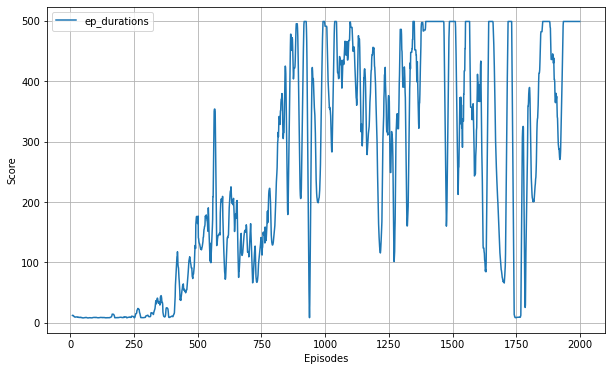

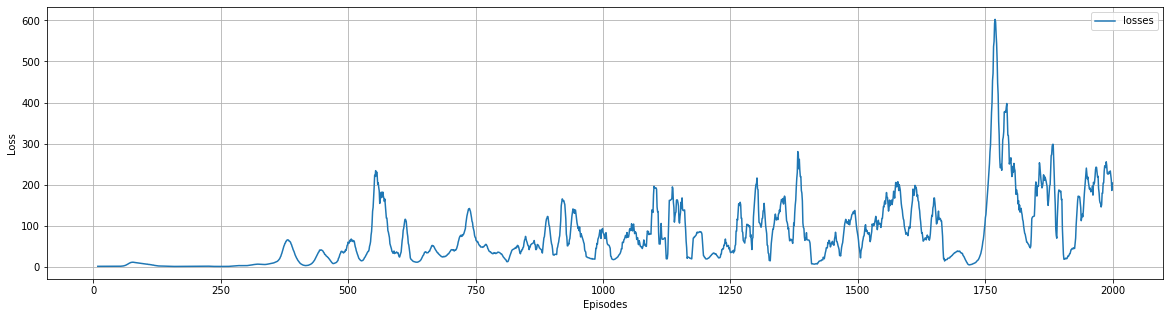

In [9]:
print(f"{len(dataset) = }")
print(f"{len(trainer.ep_durations) = }")

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(pd.Series(trainer.ep_durations).rolling(10).mean(), label="ep_durations")
plt.legend()
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.show()

plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(pd.Series(trainer.losses).rolling(10).mean(), label="losses")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Episodes")
plt.show()

### Now let's actually see our convoluted neural network based model play!

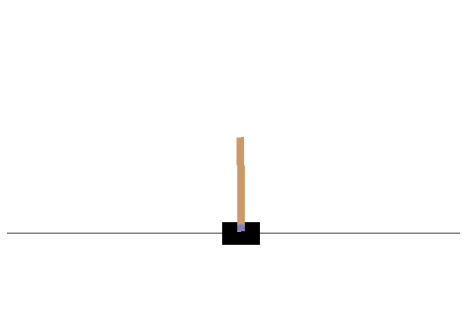

In [10]:
data = HistoryDataset(ENV, 256, produce_gif=True)

done = False
state = data.reset()
counter = 0
for i in range(1000):
    if done:
        counter += 1
        if counter == 200:
            counter = 0
            state = data.reset()
        done = False
        continue
        
    action = CNNagent.action(state.unsqueeze(0))
    action = action[0][0].item()
    state, reward, done = data.step(action)
    
# You can change the name of the saved gif here!
data.save_frames_as_gif(filename="CNNAgent.gif")